# Transient analysis of a 7-turn REBCO pancake coil

This script is used to simulate the transient analysis of a n-turn pancake coil with and without coating. The lumped model considers one inductor in parallel with the contact resistance for each turn. 
We use the field decay time constant as a measured of how much the contact resistance can supress eddy currents.

- We consider the case of a 7-turns REBCO pancake coil. 
- First we analyze a case without coating, so that the inter-tape resistance is calculated only with contact resistivity. 
- In the second case we analyze a coil with coating, so that the inter-tape resistance is calculated with contact contact resistivity of 1E-8 Ohm m^2 and different values of the coating resistivity. 



In [1]:
# Import libraries to use 
import numpy as np
import matplotlib.pyplot as plt
import math       
import scipy as sp
import scipy.optimize
import subprocess # Library to run ngspice on shell
import seaborn as sns # Library to change the color palette for plots
import random
import timeit # To time computing time
import warnings # To supress warnings
import string
import pandas as pd

import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
axis_font = {'size':'18','fontname':'Times New Roman'}

del matplotlib.font_manager.weight_dict['roman']
matplotlib.font_manager._rebuild()

## Important functions

In [2]:
# Magnetic field at the center of single pancake coil

def Bz(I,r):
    u0 = 4*np.pi*(10**(-7))
    field = u0*I/(2*r)
    return np.array(field)

# Getting raddi in an array

def radii_array(N,Di,t): # Imputs are number of turns,inner diameter, and thickness of tape
    r = []
    for j in range(N):
        if j == 0:
            r.append(Di/2 + t/2)
        else:
            r.append(Di/2 + t/2 + t*j)
    return np.array(r)  

# Contact resistance calculation

def contact_resistance(r,w,p): # Input: radii, width, and contact resistivity
    #p = 1E-8 # Ohm m^2 Contact resistivity 
    S = 2*math.pi*r*w # Cross section to get the total contact resistance of each turn
    Rc = p/S # Contact resistance for each turn
    return Rc

def coating_resistance(r,w,p,t): # Input: radii, width, and coating resistivity
    #p = 1E-8 # Ohm m^2 Contact resistivity 
    S = 2*math.pi*r*w # Cross section to get the total contact resistance of each turn
    Rt = p*t/S # Contact resistance for each turn
    return Rt

# Plot Settings

def plotsettings(xlabel,ylabel,title):
    plt.xlabel(xlabel, fontname='Times New Roman')
    plt.ylabel(ylabel,fontname='Times New Roman')
    plt.title(title,fontname='Times New Roman')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    #plt.legend()
    plt.grid()
    
# Fitting magnetic field functions 

def model_func(t, B, tau): # Exponential decay of magnetic field
    return B * np.exp(t/tau)

def fit_exp_linear(t,y): # Fitting exponential function
    y = np.log(y)
    tau, B_log = np.polyfit(t, y,1)
    B = np.exp(B_log)
    return B,tau

# Fitting non linear function 
def fit_exp_nonlinear(t,y,B0,tau0): #B0,tau0 are guessed initial values not necessarily the ones calculated after this.
    opt_parms, parm_cov = sp.optimize.curve_fit(model_func, t, y,(B0,tau0))
    B,tau = opt_parms
    return B,tau

In [3]:
# This function is used to run the netlist in ngspice and load the data generated by the program. 

def readdata(filename,Labels):
    out = subprocess.run(['ngspice', '-b', filename], 
                         stdout=subprocess.PIPE,  stderr=subprocess.PIPE)
    
    name = filename[:-4]+'.txt' # Name of the file to save output from ngspice
    
    # This saves output data in txt file
    with open(name, 'w') as output:
        for line in out.stdout.decode('ascii').split('\n'):
            output.write(line+'\n') # Writing output lines 
    
    # We get the data into an array 
    fill = np.zeros (len(Labels), dtype=int)
    
    f = open (name, 'r');
    src = []
    while True:  
        line = f.readline()
        if not line: break  # end of file
        if line[0] == '#':
            continue # treat next line
        src.append(line)

    #print(src)
    #data = np.zeros ([Data_points, len(Labels)])
    
    flag = False
    for line in src:
        #print line
        # Here we initialize the ngspice data array
        
        if line.startswith('No.'):
            temp_list = line.split(":")
            Data_points = int(temp_list[-1])
            #print(Data_points)
            data = np.zeros ([Data_points, len(Labels)])
            #print(data.shape)
        
        
        
        # Here we determine the indexes for the current columns
        if line.startswith('Index'):
            flag = True
            temp_list = [str(x) for x in line.split()]
            #print(temp_list)
            n_columns = len(temp_list)
            #print('n_columns\n',n_columns)
            index = np.zeros(n_columns, dtype = int)

            for j in range(n_columns):
                index [j] = Labels.index(temp_list[j])
            #print index

        # if the line starts with a number, we treat it as the data line
        if flag == True: # Only if the first index has passed for the ac analysis
            if line[0].isdigit():
                temp_data = [float(x) for x in line.split()]

                for c in range(n_columns):
                    r = fill[c]
                    #print(r, index [c])

                    data [r][index[c]] = temp_data [c]

                    fill [c] = fill [c] + 1
                    if fill [c] == Data_points:
                        fill [c] = 0
    return data


### Pancake coil without coating

0.03501408748021698
Rc [5.67166189e-05 5.65145785e-05 5.63139725e-05 5.61147855e-05
 5.59170027e-05 5.57206092e-05 5.55255904e-05]
Average Rc 5.611759396162261e-05
@l1[i] @l2[i] @l3[i] @l4[i] @l5[i] @l6[i] @l7[i] @r1[i] @r2[i] @r3[i] @r4[i] @r5[i] @r6[i] @r7[i] 
Rc [2.26866476e-05 2.26058314e-05 2.25255890e-05 2.24459142e-05
 2.23668011e-05 2.22882437e-05 2.22102362e-05]
Average Rc 2.2447037584649037e-05
@l1[i] @l2[i] @l3[i] @l4[i] @l5[i] @l6[i] @l7[i] @r1[i] @r2[i] @r3[i] @r4[i] @r5[i] @r6[i] @r7[i] 
Rc [1.13433238e-05 1.13029157e-05 1.12627945e-05 1.12229571e-05
 1.11834005e-05 1.11441218e-05 1.11051181e-05]
Average Rc 1.1223518792324518e-05
@l1[i] @l2[i] @l3[i] @l4[i] @l5[i] @l6[i] @l7[i] @r1[i] @r2[i] @r3[i] @r4[i] @r5[i] @r6[i] @r7[i] 
Rc [5.67166189e-06 5.65145785e-06 5.63139725e-06 5.61147855e-06
 5.59170027e-06 5.57206092e-06 5.55255904e-06]
Average Rc 5.611759396162259e-06
@l1[i] @l2[i] @l3[i] @l4[i] @l5[i] @l6[i] @l7[i] @r1[i] @r2[i] @r3[i] @r4[i] @r5[i] @r6[i] @r7[i] 
Rc [2.

<IPython.core.display.Javascript object>


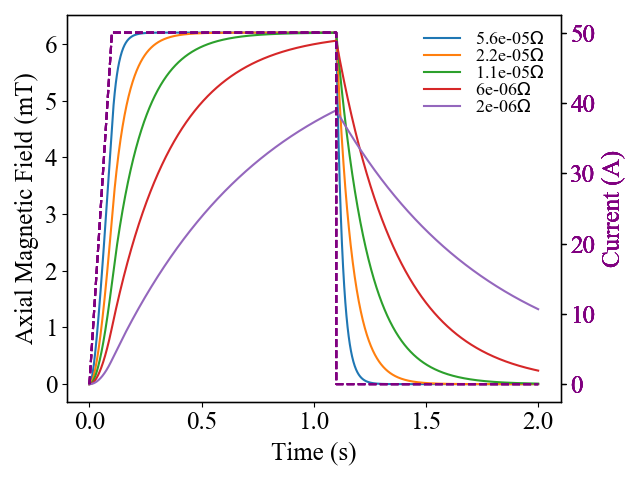

In [6]:
# First we analyze a case withoug coating sweeping the values of the contact resistance

Di = 0.22/(math.pi) # [m] Inner diameter of the coil
print(Di/2)
t = 0.1254E-3 # m Thickness of the coil (THICKNESS OF 1 TAPE)
w = 4E-3 # m Width of the tape
N = 7 # Number of turns 
radii = radii_array(N,Di,t) # Calculating inner radius for each turn
# rho = 1E-8 # [Ohm m^2] typical value of the contact resistance 
rho = [5E-8,2E-8,1E-8,0.5E-8,0.2E-8] # [Ohm m^2] contact resistance

fname = ['Without coating',0.001,0.01,0.1,1]
#fname1 = ['200','100','10','1']

#----- In this block a spice netlist for each value of the contact resistance is created----
Rc_array= []
for k in range(len(rho)):
    R_c = contact_resistance(radii,w,rho[k]) 
    #Rt = coating_resistance(radii,w,pf_LN[k],0.5E-6)
   
    Rc = R_c #+ Rt
    Rc_array.append(np.average(Rc))
    print('Rc',Rc)
    print('Average Rc',np.average(Rc))
    L = [1.47427E-6, 1.55699E-6, 1.60131E-6, 1.61788E-6, 
    1.60881E-6, 1.57153E-6, 1.49406E-6] # Total inductance of each turn (self + mutual inductances)

    # Printing the labels of the elements to read current for this case
    Labels = ['Index','time']
    
    # Current in inductances
    for i in range(len(L)):
            Labels.append(f'@l{i+1}[i]')
    
    # Current in resistances
    for i in range(len(L)):
            Labels.append(f'@r{i+1}[i]')
            
    probe = ''
    for i in range(len(Labels)-2):
        probe = probe + Labels[i+2]+' '
    print(probe)
    
    # Generating netlist 
    with open(f'7turns{rho[k]}.cir', 'w') as output:
        output.write('* Netlist for 7 turns coil\n') # Name of the circuit as a comment
        output.write('I1 0 1 PULSE(0 50 0 0.1 1f 1)\n') # Current source
        #output.write(f'I1 0 1 PULSE(0 {Imax} 0 {t_rise} {t_fall} {t_on})\n') # Pulse I_start I_max t_delay t_rise t_fall t_on
        
        output.write('.option rser = 0\n') #to make inductance default value 0
        
        # Creating nodes for each resitor and inductor
        for i in range(len(L)):
            ni = i+1
            nf = i+2
            if i<len(L)-1:
                output.write(f'L{ni} {ni} {nf} {L[i]}\n') # Inductance
                output.write(f'R{ni} {ni} {nf} {Rc[i]}\n') # Contact resistance
            else: # The last turn is connected to ground
                output.write(f'L{ni} {ni} 0 {L[i]}\n') # Inductance
                output.write(f'R{ni} {ni} 0 {Rc[i]}\n') # Contact resistance
        
        output.write('.options savecurrents\n')
        output.write('.tran 0.001 2\n')
        output.write('.print tran '+probe+'\n')
        output.write('.end\n')
        
#------------ Running spice and plotting results -----------------------
%matplotlib notebook 

fig, ax1 = plt.subplots() 
plt.yticks(**axis_font)
plt.xticks(**axis_font)

tau_lumped = []
tau_fit = []
for k in range(len(rho)):
    
    # Getting currents from inductors
    
    
    filename = f'7turns{rho[k]}.cir' # File for certain value of the contact resistivity
    data = readdata(filename,Labels) # Running ngspice and getting data
    time = data[:,1]
    
    I = np.zeros((N,len(time))) # Creating array to save data
    for i in range(N):
        I[i][:] = data[:,2+i] # Saving current
        
    Isource = data[:,2]+data[:,2+N] # Input current

    # Calculating magnetic field 
    Bfield = np.zeros(len(time))

    for i in range(N):
        Bfield = Bfield+Bz(I[i],radii[i]) # Adding field from each turn

    ax1.set_xlabel('Time (s)', **axis_font)
    ax1.set_ylabel('Axial Magnetic Field (mT)', **axis_font)
    ax1.plot(time, Bfield/1e-3,label= f'{round(Rc_array[k],6)}'+'$\Omega$')
    ax1.tick_params(axis='y')
    #ax1.legend(**axis_font)
    ax1.legend(labelspacing=0.001,ncol=1,loc='upper right',prop={'family':'Times New Roman', 'size':13}).get_frame().set_linewidth(0.0)
    
    # Plotting transport current (I1 current source)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'purple'
    ax2.set_ylabel('Current (A)', color=color,**axis_font)  # we already handled the x-label with ax1
    ax2.plot(time, Isource,'--',color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    #ax2.set_ylim(-5,100)
    plt.xticks(**axis_font)
    plt.yticks(**axis_font)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    #---  Calculating the field decay constant 
    t = []
    Bdecay = []
    for i in range(len(time)): 
        t1,B1 = time[i],Bfield[i]
        Blim = 1e-10 # Lowest Bfield to take
        if t1>=1.1 and B1>=Blim: # 1.1 s is the time from the simulation when the I1 source is turn off
            t.append(time[i])
            Bdecay.append(Bfield[i])
    t,Bdecay = np.array(t), np.array(Bdecay)
    t = t-t[0] # setting time to zero

    # Fitting 

    # Bfield from lumped model parameters
    B0 = Bdecay[0]
    tau0 = -sum(L)/sum(Rc)
    tau_lumped.append(tau0)

    # Non linear fitting
    Bn,taun = fit_exp_nonlinear(t,Bdecay,B0,tau0)
    tau_fit.append(taun)


   
    
plt.savefig('7turn_withoutcoating_-discharging.png')



<IPython.core.display.Javascript object>


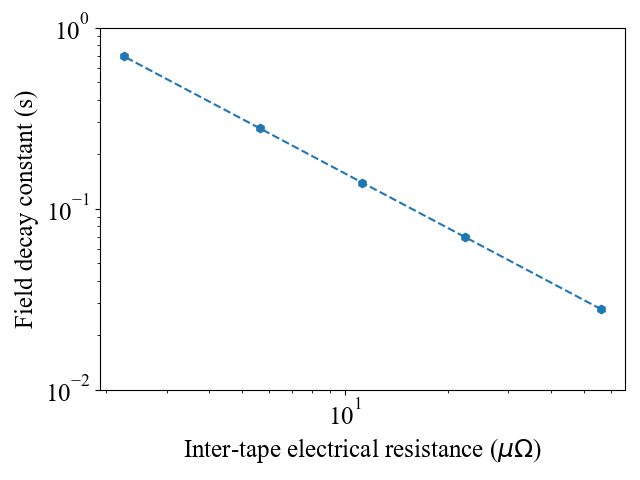

In [7]:
# Plotting results of the field decay constant for different values of inter-tape resistance 

tau_lumped = np.asarray(tau_lumped)
tau_fit = np.asanyarray(tau_fit) # Decay constant calculated from fitting
#pf_LN = [0,0.001,0.01,0.1,1]
%matplotlib notebook 
Rc_array = np.asanyarray(Rc_array)
fig, ax1 = plt.subplots() 
plt.yticks(**axis_font)
plt.xticks(**axis_font)
#resistivity_coating = np.asarray(pf_LN[1:])*100

ax1.set_xlabel('Inter-tape electrical resistance ($\mu\Omega$)', **axis_font)
ax1.set_ylabel('Field decay constant (s)', **axis_font)
#ax1.plot(pf_LN, tau_lumped,label= f'lumped')
ax1.loglog(Rc_array/1e-6, -tau_fit,'--h',label= f'fit')
ax1.set_ylim(1e-2,1)
#ax1.legend(**axis_font)
#ax1.legend(labelspacing=0.001,ncol=1,loc='upper right',prop={'family':'Times New Roman', 'size':13}).get_frame().set_linewidth(0.0)

plt.tight_layout()
plt.savefig('decayconstant_contact.png')

### Now we analyze the coil with coating

0.03501408748021698
Rc [1.13433238e-05 1.13029157e-05 1.12627945e-05 1.12229571e-05
 1.11834005e-05 1.11441218e-05 1.11051181e-05]
Average Rc 1.1223518792324518e-05
@l1[i] @l2[i] @l3[i] @l4[i] @l5[i] @l6[i] @l7[i] @r1[i] @r2[i] @r3[i] @r4[i] @r5[i] @r6[i] @r7[i] 
Rc [1.70149857e-05 1.69543736e-05 1.68941917e-05 1.68344357e-05
 1.67751008e-05 1.67161828e-05 1.66576771e-05]
Average Rc 1.683527818848678e-05
@l1[i] @l2[i] @l3[i] @l4[i] @l5[i] @l6[i] @l7[i] @r1[i] @r2[i] @r3[i] @r4[i] @r5[i] @r6[i] @r7[i] 
Rc [6.80599427e-05 6.78174942e-05 6.75767670e-05 6.73377426e-05
 6.71004032e-05 6.68647310e-05 6.66307085e-05]
Average Rc 6.734111275394712e-05
@l1[i] @l2[i] @l3[i] @l4[i] @l5[i] @l6[i] @l7[i] @r1[i] @r2[i] @r3[i] @r4[i] @r5[i] @r6[i] @r7[i] 
Rc [0.00057851 0.00057645 0.0005744  0.00057237 0.00057035 0.00056835
 0.00056636]
Average Rc 0.0005723994584085505
@l1[i] @l2[i] @l3[i] @l4[i] @l5[i] @l6[i] @l7[i] @r1[i] @r2[i] @r3[i] @r4[i] @r5[i] @r6[i] @r7[i] 
Rc [0.00568301 0.00566276 0.0056426

<IPython.core.display.Javascript object>


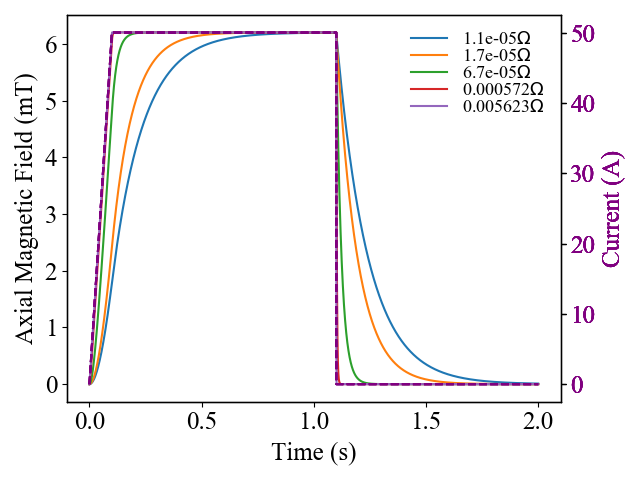

In [10]:
# Now the case with coating
# The script is the same as in the case without coating, the only difference is that in this case we add the coating 
# resistance plus the contact resistance for the inter-tape resistance

Di = 0.22/(math.pi) # m Inner diameter of the coil
print(Di/2)
t = 0.1254E-3 # m Thickness of the coil (THICKNESS OF 1 TAPE)
w = 4E-3 # m Width of the tape
N = 7
radii = radii_array(N,Di,t)
rho = 1E-8 # [Ohm m^2] contact resistivity is constant for all cases
pf_LN = [0,0.01,0.1,1,10] # [Ohm m] VOx resistivity at 77 K (VALUE FOR TAPE 26)



Rc_array= []
for k in range(len(pf_LN)):
    R_c = contact_resistance(radii,w,rho) 
    Rt = coating_resistance(radii,w,pf_LN[k],0.5E-6) # Transverse contact resistance 
   
    Rc = R_c + Rt # The intertape resistance adds constant contact resistance and transverse coating resistance
    Rc_array.append(np.average(Rc))
    print('Rc',Rc)
    print('Average Rc',np.average(Rc))
    L = [1.47427E-6, 1.55699E-6, 1.60131E-6, 1.61788E-6, 
    1.60881E-6, 1.57153E-6, 1.49406E-6] # total inductance for the 7-turns

    # Printing the labels of the elements to read current for this case
    Labels = ['Index','time']
    
    # Inductances
    for i in range(len(L)):
            Labels.append(f'@l{i+1}[i]')
    
    for i in range(len(L)):
            Labels.append(f'@r{i+1}[i]')
            
    probe = ''
    for i in range(len(Labels)-2):
        probe = probe + Labels[i+2]+' '
    print(probe)
    
    # Generating netlist 
    with open(f'7turns{pf_LN[k]}.cir', 'w') as output:
        output.write('* Netlist for 7 turns coil\n') # Name of the circuit as a comment
        output.write('I1 0 1 PULSE(0 50 0 0.1 1f 1)\n') # Current source
        #output.write(f'I1 0 1 PULSE(0 {Imax} 0 {t_rise} {t_fall} {t_on})\n') # Pulse I_start I_max t_delay t_rise t_fall t_on
        
        output.write('.option rser = 0\n') #to make inductance default value 0
        
        # Creating nodes for each resitor and inductor
        for i in range(len(L)):
            ni = i+1
            nf = i+2
            if i<len(L)-1:
                output.write(f'L{ni} {ni} {nf} {L[i]}\n') #L1 0 N001 51.7E-6 Rser=0
                output.write(f'R{ni} {ni} {nf} {Rc[i]}\n')
            else:
                output.write(f'L{ni} {ni} 0 {L[i]}\n')
                output.write(f'R{ni} {ni} 0 {Rc[i]}\n')

        output.write('.options savecurrents\n')
        output.write('.tran 0.001 2\n')
        #output.write(f'.tran {step} {t_tot}\n')
        output.write('.print tran '+probe+'\n')
        output.write('.end\n')
        
        
%matplotlib notebook 

fig, ax1 = plt.subplots() 
plt.yticks(**axis_font)
plt.xticks(**axis_font)

tau_lumped = []
tau_fit = []
for k in range(len(pf_LN)):
    
    # Getting currents from inductors
    
    
    filename = f'7turns{pf_LN[k]}.cir'
    data = readdata(filename,Labels)
    time = data[:,1]
    
    I = np.zeros((N,len(time))) # Creating array to save data
    for i in range(N):
        I[i][:] = data[:,2+i]
        
    Isource = data[:,2]+data[:,2+N]

    Bfield = np.zeros(len(time))

    for i in range(N):
        #plt.plot(time,Bz(I[i],radii[i]))
        Bfield = Bfield+Bz(I[i],radii[i])

    ax1.set_xlabel('Time (s)', **axis_font)
    ax1.set_ylabel('Axial Magnetic Field (mT)', **axis_font)
    ax1.plot(time, Bfield/1e-3,label= f'{round(Rc_array[k],6)}'+'$\Omega$')
    ax1.tick_params(axis='y')
    ax1.set_ylim()
    #ax1.legend(**axis_font)
    ax1.legend(labelspacing=0.001,ncol=1,loc='upper right',prop={'family':'Times New Roman', 'size':13}).get_frame().set_linewidth(0.0)
    
    

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    #plt.yticks(**axis_font)
    color = 'purple'
    ax2.set_ylabel('Current (A)', color=color,**axis_font)  # we already handled the x-label with ax1
    ax2.plot(time, Isource,'--',color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    #ax2.set_ylim(-5,100)
    plt.xticks(**axis_font)
    plt.yticks(**axis_font)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    #---- Calculating magnetic field and decay constant 
    t = []
    Bdecay = []
    for i in range(len(time)): 
        t1,B1 = time[i],Bfield[i]
        Blim = 1e-10 # Lowest Bfield to take
        if t1>=1.1 and B1>=Blim: # 1.1 s is the time from the simulation when the I source is turn off
            t.append(time[i])
            Bdecay.append(Bfield[i])
    t,Bdecay = np.array(t), np.array(Bdecay)
    t = t-t[0] # setting time to zero

    # Fitting 


    # Bfield from lumped model parameters
    B0 = Bdecay[0]
    tau0 = -sum(L)/sum(Rc)
    tau_lumped.append(tau0)

    # Non linear fitting
    Bn,taun = fit_exp_nonlinear(t,Bdecay,B0,tau0)
    tau_fit.append(taun)


   
    
plt.savefig('7turn_with-coating.png')




<IPython.core.display.Javascript object>


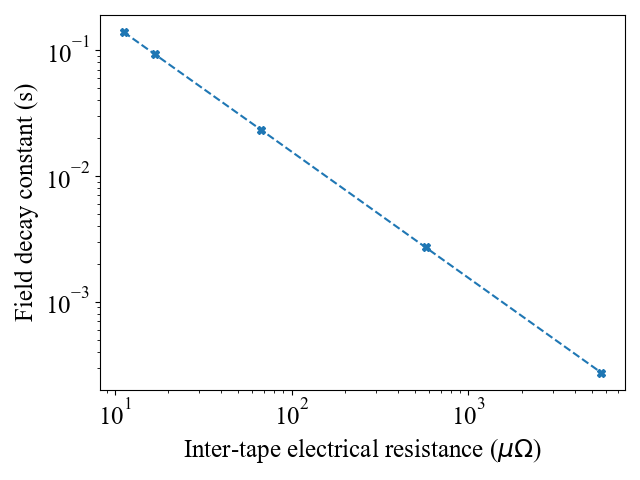

In [11]:
# Plotting the field decay constant for pancake coil with coating

tau_lumped = np.asarray(tau_lumped)
tau_fit = np.asanyarray(tau_fit)
#pf_LN = [0,0.001,0.01,0.1,1]
%matplotlib notebook 
Rc_array = np.asanyarray(Rc_array)
fig, ax1 = plt.subplots() 
plt.yticks(**axis_font)
plt.xticks(**axis_font)
#resistivity_coating = np.asarray(pf_LN[1:])*100

ax1.set_xlabel('Inter-tape electrical resistance ($\mu\Omega$)', **axis_font)
ax1.set_ylabel('Field decay constant (s)', **axis_font)
#ax1.plot(pf_LN, tau_lumped,label= f'lumped')
ax1.loglog(Rc_array/1e-6, -tau_fit,'--X',label= f'fit')

plt.tight_layout()
plt.savefig('decayconstant_coating.png')